In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import ruptures as rpt

In [2]:
ecg_dataset = pd.read_csv('ecg.csv', header=None)
microsoft_stocks_dataset = pd.read_csv('Microsoft_Stock.csv')
month_value_dataset = pd.read_csv('Month_Value_1.csv')
yahoo_stocks_dataset = pd.read_csv('yahoo_stock.csv')

ecg_columns = [f'ECG_{i+1}' for i in range(140)]
ecg_dataset.columns = ecg_columns + ['label']

yahoo_stocks_dataset['Date'] = pd.to_datetime(yahoo_stocks_dataset['Date'])

In [3]:
month_value_dataset.columns

Index(['Period', 'Revenue', 'Sales_quantity', 'Average_cost',
       'The_average_annual_payroll_of_the_region'],
      dtype='object')

<Axes: >

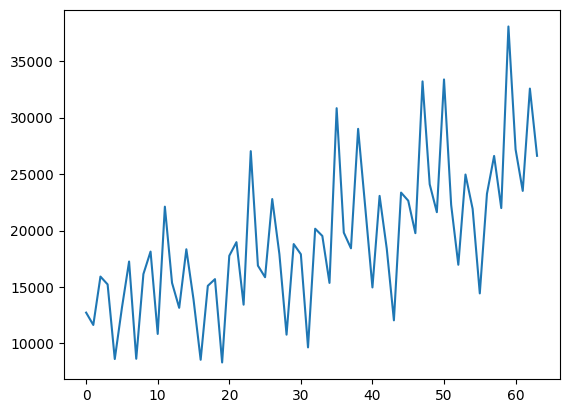

In [4]:
month_value_dataset['Sales_quantity'].plot()

In [5]:
microsoft_stocks_dataset.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

<Axes: >

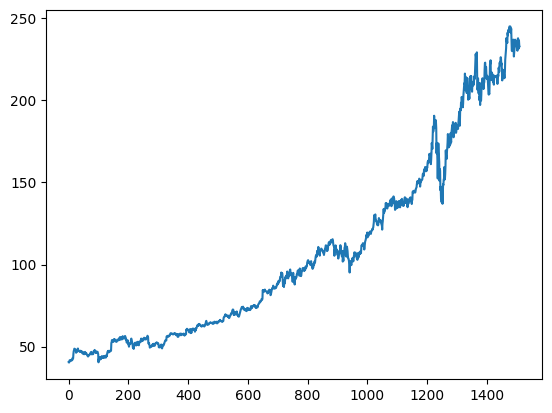

In [6]:
microsoft_stocks_dataset['Open'].plot()

<Axes: >

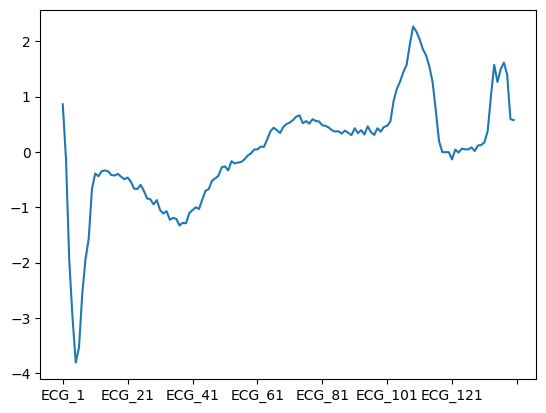

In [7]:
ecg_dataset.loc[40, ecg_columns].plot()

In [8]:
yahoo_stocks_dataset.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

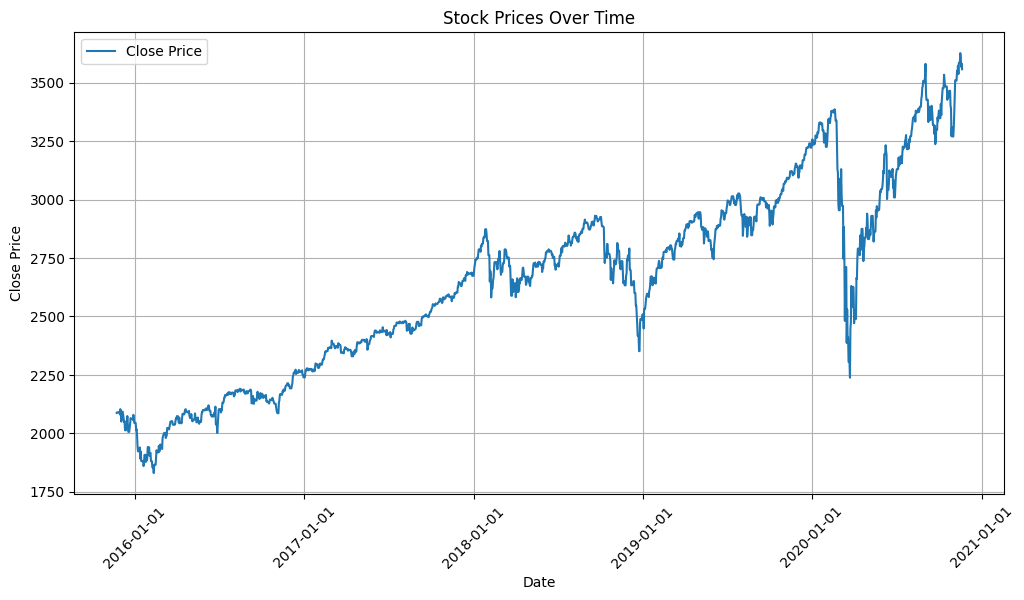

In [9]:
# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(yahoo_stocks_dataset['Date'], yahoo_stocks_dataset['Close'], label="Close Price")

# Format the x-axis to show some dates
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())  # Automatically chooses a good interval
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format as YYYY-MM-DD

# Rotate dates for better visibility
plt.xticks(rotation=45)

# Labels and title
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [10]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset
from time_series_segmentation_benchmark.tssb.utils import load_time_series_segmentation_datasets
from time_series_segmentation_benchmark.tssb.evaluation import covering

In [11]:
dataset, window_size, true_cps, time_series = load_tssb_dataset(names=("CricketX",)).iloc[0,:]
clasp = BinaryClaSPSegmentation()
clasp.fit_predict(time_series)

array([ 712, 1281, 1933, 2581])

array([<Axes: title={'center': 'Segmentation of different umpire cricket signals'}, ylabel='ACC'>,
       <Axes: xlabel='split point', ylabel='ClaSP Score'>], dtype=object)

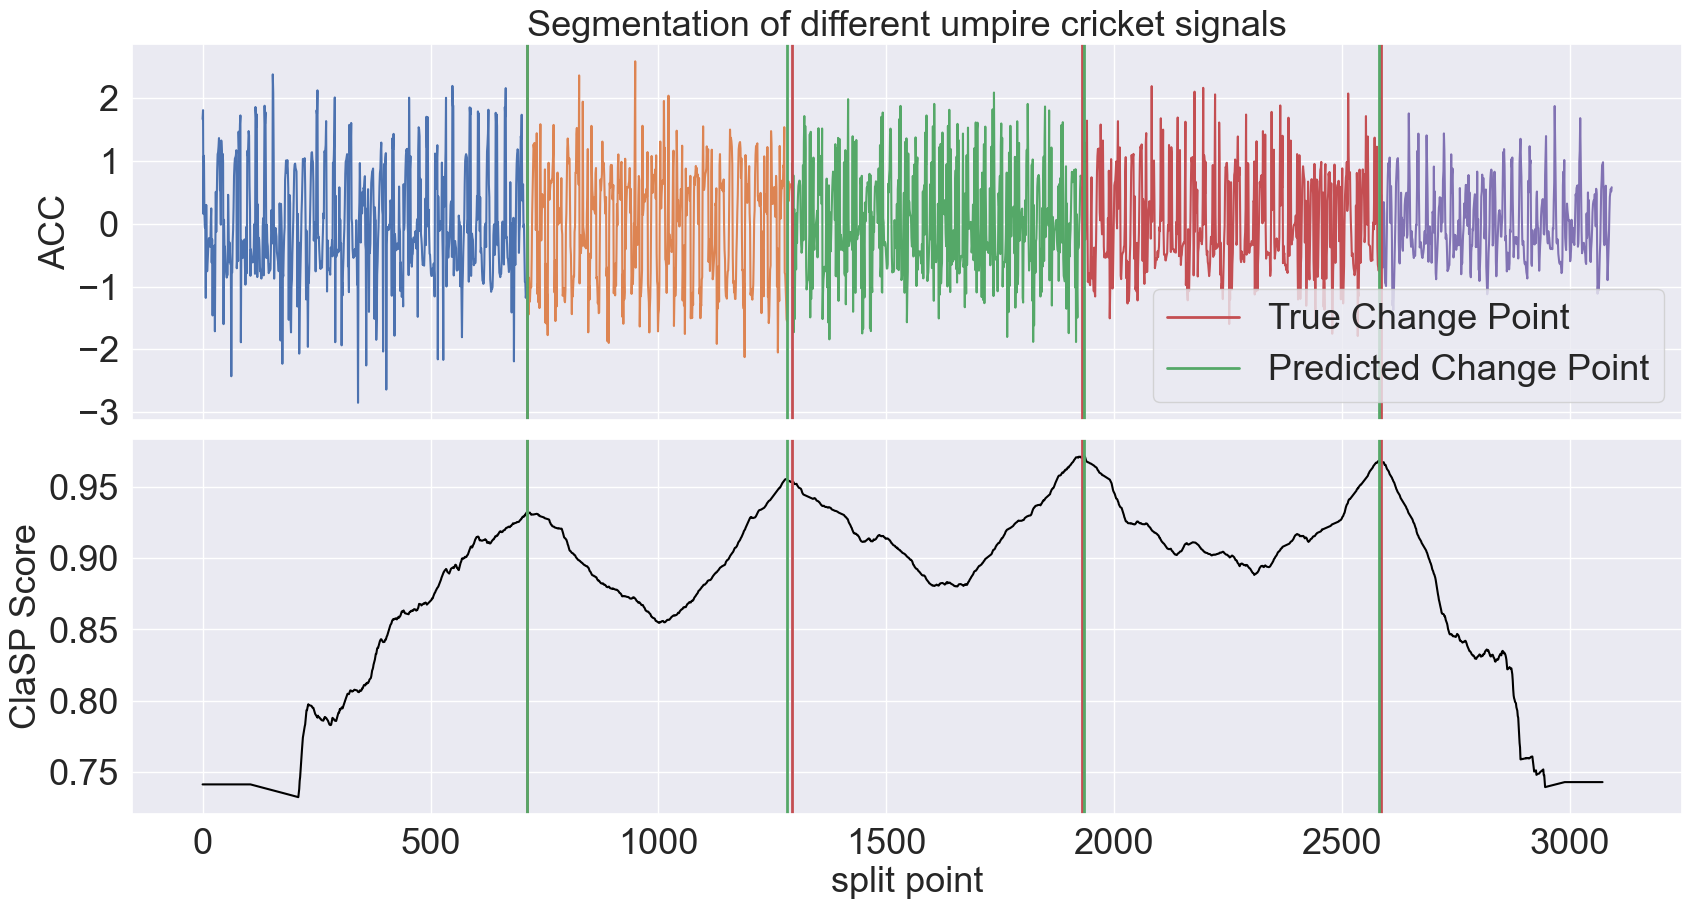

In [12]:
clasp.plot(gt_cps=true_cps, heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

In [13]:
tssb = load_time_series_segmentation_datasets()

In [14]:
score_sum = 0

for _, (ts_name, window_size, cps, ts) in tssb.iterrows():
   found_cps = rpt.Pelt(model="l2").fit(ts).predict(pen=window_size)
   score = covering({0: cps}, found_cps, ts.shape[0])
   print(f"Time Series: {ts_name}: True Change Points: {cps}, Found Change Points: {found_cps}, Score: {score}")
   score_sum += score

print(f"Average Score: {score_sum / len(tssb)}")

Time Series: Adiac: True Change Points: [ 572 1012 1232], Found Change Points: [1408], Score: 0.302734375
Time Series: ArrowHead: True Change Points: [753], Found Change Points: [5, 20, 45, 55, 70, 80, 105, 120, 130, 170, 180, 195, 245, 255, 310, 320, 370, 380, 435, 445, 460, 480, 495, 505, 560, 570, 590, 605, 620, 635, 645, 670, 685, 695, 750, 760, 775, 795, 810, 820, 840, 855, 870, 885, 900, 915, 935, 945, 965, 980, 1000, 1010, 1025, 1045, 1060, 1070, 1090, 1105, 1125, 1135, 1155, 1170, 1185, 1200, 1215, 1230, 1250, 1260, 1280, 1295, 1310, 1325, 1340, 1360, 1375, 1385, 1405, 1420, 1435, 1450, 1465, 1485, 1500, 1506], Score: 0.049800796812749
Time Series: Beef: True Change Points: [705], Found Change Points: [1410], Score: 0.5
Time Series: BeetleFly: True Change Points: [1280], Found Change Points: [25, 60, 80, 265, 295, 325, 355, 390, 400, 410, 430, 440, 450, 565, 575, 700, 710, 755, 765, 775, 790, 815, 825, 870, 910, 920, 940, 950, 975, 1030, 1050, 1060, 1085, 1120, 1145, 1180, 1215

In [73]:
score_sum = 0

for _, (ts_name, window_size, cps, ts) in tssb.iterrows():
   found_cps = BinaryClaSPSegmentation().fit_predict(ts)
   score = covering({0: cps}, found_cps, ts.shape[0])
   print(f"Time Series: {ts_name}: True Change Points: {cps}, Found Change Points: {found_cps}, Score: {score}")
   score_sum += score

print(f"Average Score: {score_sum / len(tssb)}")

Time Series: Adiac: True Change Points: [ 572 1012 1232], Found Change Points: [ 567 1015 1235], Score: 0.9845337888008853
Time Series: ArrowHead: True Change Points: [753], Found Change Points: [752], Score: 0.9986728594023552
Time Series: Beef: True Change Points: [705], Found Change Points: [], Score: 0.5
Time Series: BeetleFly: True Change Points: [1280], Found Change Points: [1287], Score: 0.9945461222804972
Time Series: BirdChicken: True Change Points: [1280], Found Change Points: [1271], Score: 0.9929932966446857
Time Series: Car: True Change Points: [ 577 1154 1550], Found Change Points: [ 564 1145], Score: 0.759432603877519
Time Series: CBF: True Change Points: [384 704], Found Change Points: [370], Score: 0.6819138418079096
Time Series: Chinatown: True Change Points: [], Found Change Points: [], Score: 1.0
Time Series: ChlorineConcentration: True Change Points: [2365], Found Change Points: [], Score: 0.5774870418254516
Time Series: CinCECGTorso: True Change Points: [2663 5121

# Change point detection

In [103]:
ecg_data = ecg_dataset[ecg_columns].values

In [124]:
# Select first ECG signal (Row 0)
which_row = 30
#ecg_signal = ecg_data[which_row]
ecg_signal = np.array(microsoft_stocks_dataset['Open'])  # Change index to analyze another row

# Apply change point detection (Pelt Algorithm with L2 cost)
algo = rpt.Pelt(model="l2").fit(ecg_signal.reshape(-1, 1))
change_points = algo.predict(pen=3000)  # Adjust 'pen' for more/less segmentation

# Print detected change points
print("Change Points Detected:", change_points)


Change Points Detected: [145, 395, 520, 650, 795, 995, 1055, 1165, 1215, 1235, 1265, 1315, 1465, 1511]


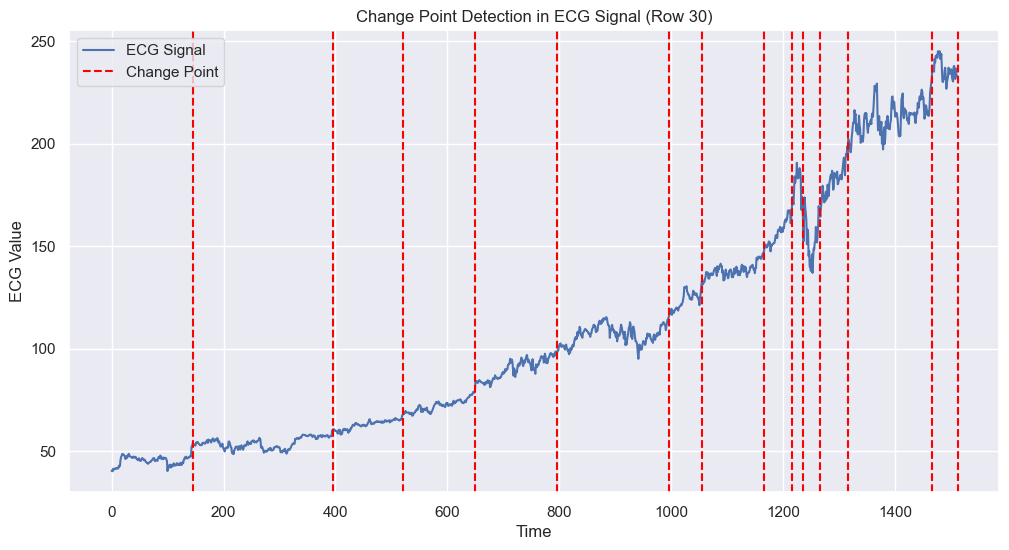

In [125]:
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal")

# Mark detected change points
for cp in change_points:
    plt.axvline(x=cp, color='red', linestyle='--', label="Change Point" if cp == change_points[0] else "")

plt.legend()
plt.title("Change Point Detection in ECG Signal (Row " + str(which_row) + ")")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.show()


# KMeans

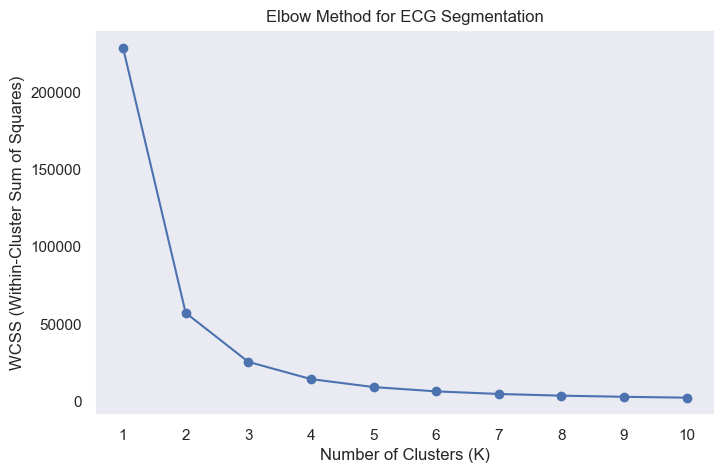

In [17]:
from sklearn.cluster import KMeans

which_row = 0

# Select one ECG signal (first row, ignoring label)
ecg_signal = ecg_dataset.iloc[which_row, :-1].values  # Assuming last column is "label"

# Create features: (time index, ECG value)
time_steps = np.arange(len(ecg_signal)).reshape(-1, 1)
X = np.column_stack((time_steps, ecg_signal))  # Combine time & ECG values

# Apply Elbow Method to find the best K
wcss = []
K_values = range(1, 11)  # Test K from 1 to 10

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(K_values, wcss, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for ECG Segmentation")
plt.xticks(K_values)
plt.grid()
plt.show()

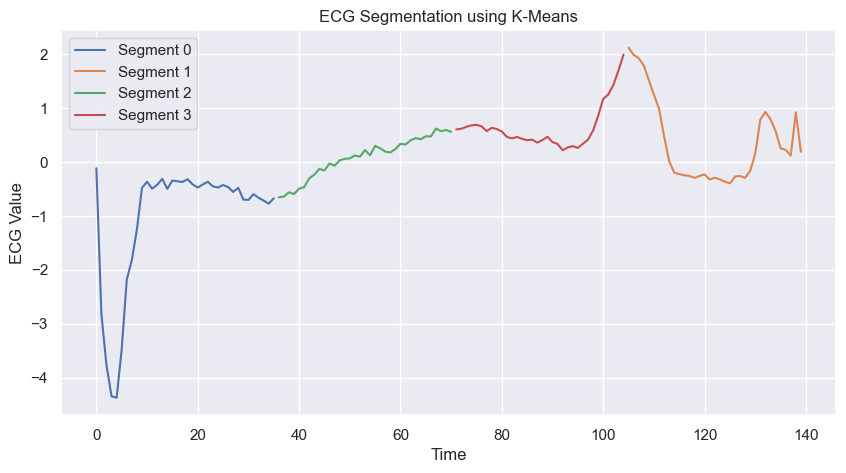

In [18]:
# Apply K-Means with the best K (replace with your best K value)
best_K = 4  # Example value, replace with the best K found from elbow method
kmeans = KMeans(n_clusters=best_K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Plot the segmented ECG signal
plt.figure(figsize=(10, 5))
for cluster in np.unique(labels):
    plt.plot(time_steps[labels == cluster], ecg_signal[labels == cluster], label=f'Segment {cluster}')

plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.title("ECG Segmentation using K-Means")
plt.legend()
plt.show()


# Time series KMeans

In [19]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


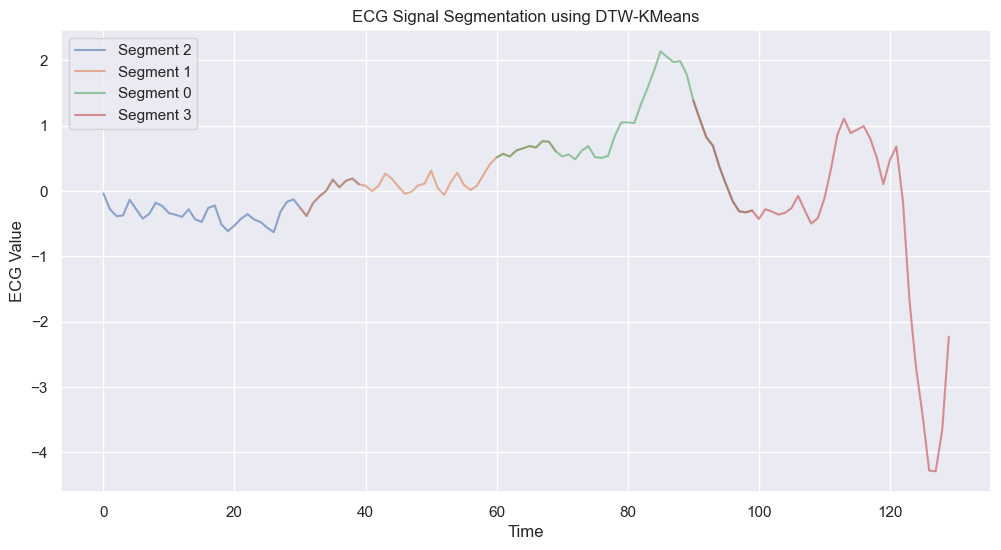

In [20]:
# Select a single ECG signal (e.g., first row)
ecg_signal = ecg_dataset.iloc[30, :-1].values  # Assuming last column is "label"

# Define segmentation parameters
window_size = 40  # Number of points per segment
stride = 30  # Step size for segment extraction

# Create overlapping segments
segments = [ecg_signal[i:i+window_size] for i in range(0, len(ecg_signal)-window_size, stride)]
segments = np.array(segments)

# Normalize segments
segments_scaled = TimeSeriesScalerMeanVariance().fit_transform(segments)

# Apply DTW-KMeans
n_clusters = 4  # Adjust based on elbow method
dtw_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", random_state=42)
labels = dtw_kmeans.fit_predict(segments_scaled)

# Plot segmented ECG signal
plt.figure(figsize=(12, 6))
time_axis = np.arange(len(ecg_signal))

for i, segment_start in enumerate(range(0, len(ecg_signal)-window_size, stride)):
    plt.plot(time_axis[segment_start:segment_start+window_size], ecg_signal[segment_start:segment_start+window_size], 
             label=f"Segment {labels[i]}", alpha=0.6)

plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.title("ECG Signal Segmentation using DTW-KMeans")
plt.legend()
plt.show()

# BinarySegmentation

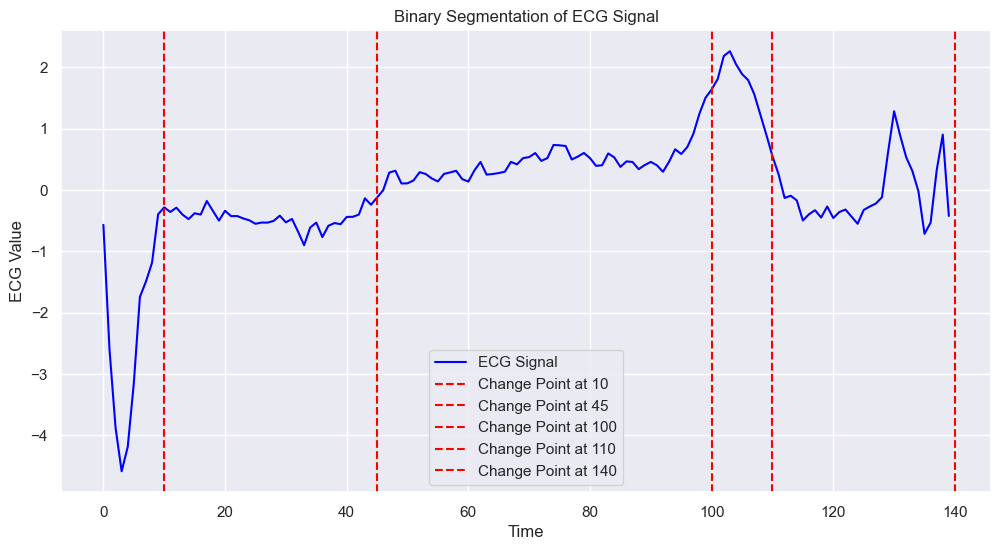

In [39]:
which_row = 2

# Select a single ECG signal (e.g., first row)
ecg_signal = ecg_dataset.iloc[which_row, :-1].values  # Assuming last column is "label"

# Define parameters for the binary segmentation
model = "l2"  # Model used for change point detection (l2: least squares)
algo = rpt.Binseg(model=model).fit(ecg_signal)  # Binary segmentation algorithm

# Detect change points
break_points = 4  # Number of change points to detect
change_points = algo.predict(n_bkps=break_points)  # Set n_bkps=1 for one change point

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ecg_signal, label="ECG Signal", color="blue")
for cp in change_points:
    plt.axvline(x=cp, color="red", linestyle="--", label=f"Change Point at {cp}")
plt.title("Binary Segmentation of ECG Signal")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.legend()
plt.show()

# TCN-based autoencoder

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils import weight_norm

In [126]:
# Define TCN Autoencoder
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, dilation=1):
        super(TCNBlock, self).__init__()
        padding = (kernel_size - 1) * dilation // 2  # Ensures output length matches input
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(out_channels)


    def forward(self, x):
        return self.batch_norm(self.relu(self.conv(x)))

In [127]:
class TCN_Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(TCN_Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            TCNBlock(1, 8, kernel_size=3, dilation=1),
            TCNBlock(8, 16, kernel_size=3, dilation=2),
            TCNBlock(16, 8, kernel_size=3, dilation=4),
        )
        self.decoder = nn.Sequential(
            TCNBlock(8, 16, kernel_size=3, dilation=4),
            TCNBlock(16, 8, kernel_size=3, dilation=2),
            nn.Conv1d(8, 1, kernel_size=3, padding=1)  # Ensures input-output match
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [128]:
# Function to train TCN Autoencoder on one ECG signal
def segment_ecg_signal(ecg_signal, epochs=50, batch_size=32, threshold_factor=3.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ecg_signal = torch.tensor(ecg_signal, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,T]
    model = TCN_Autoencoder(ecg_signal.shape[-1]).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop
    for _ in range(epochs):
        optimizer.zero_grad()
        output = model(ecg_signal)
        loss = criterion(output, ecg_signal)
        loss.backward()
        optimizer.step()
    
    # Compute reconstruction error
    reconstruction_error = torch.abs(output.squeeze(0).squeeze(0) - ecg_signal.squeeze(0).squeeze(0)).cpu().detach().numpy()
    threshold = reconstruction_error.mean() + threshold_factor * reconstruction_error.std()
    change_points = np.where(reconstruction_error > (reconstruction_error.mean() + 2.0 * reconstruction_error.std()))[0]

    # Get reconstructed signal
    reconstructed_signal = output.squeeze(0).squeeze(0).cpu().detach().numpy()
    original_signal = ecg_signal.squeeze(0).squeeze(0).cpu().detach().numpy()

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(ecg_signal.squeeze().cpu().numpy(), label="Original Signal")
    plt.plot(reconstruction_error, label="Reconstruction Error", color='orange')
    plt.plot(reconstructed_signal, label="Reconstructed Signal", linestyle='dashed')
    plt.scatter(change_points, ecg_signal.squeeze().cpu().numpy()[change_points], color='red', label="Change Points")
    plt.legend()
    plt.title("ECG Segmentation using TCN Autoencoder")
    plt.show()

    return change_points

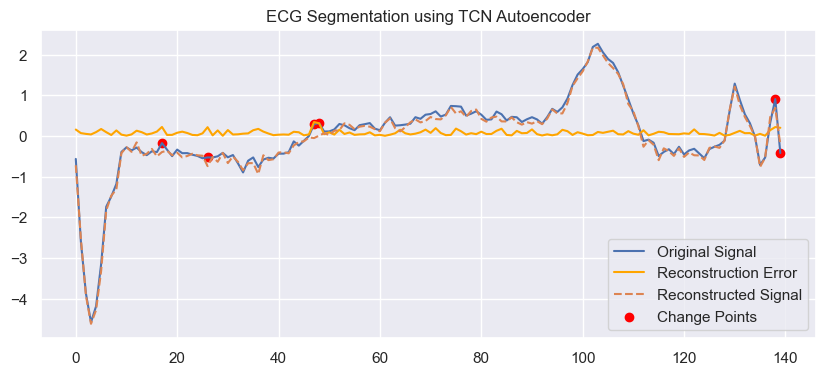

Detected change points: [ 17  26  47  48 138 139]


In [129]:
# Example usage (assuming 'ecg_df' is your dataset)
ecg_signal = ecg_dataset.iloc[2, :-1].values  # Selecting the first row (one signal)
change_points = segment_ecg_signal(ecg_signal)
print("Detected change points:", change_points)

In [69]:
score_sum = 0

for _, (ts_name, window_size, cps, ts) in tssb.iterrows():
   found_cps = segment_ecg_signal(ts)
   score = covering({0: cps}, found_cps, ts.shape[0])
   print(f"Time Series: {ts_name}: True Change Points: {cps}, Found Change Points: {found_cps}, Score: {score}")
   score_sum += score

print(f"Average Score: {score_sum / len(tssb)}")

Time Series: Adiac: True Change Points: [ 572 1012 1232], Found Change Points: [   0    1    2    3    4 1254 1287 1292 1298 1309 1315 1320 1358 1379
 1384 1386 1396 1401 1404 1406 1407], Score: 0.34849980063795855
Time Series: ArrowHead: True Change Points: [753], Found Change Points: [   0    1    2    3   12   31   32  104  141  142  144  145  156  158
  159  165  169  170  223  233  268  269  280  281  303  331  332  333
  335  343  345  347  348  349  359  369  394  395  406  455  457  458
  460  462  463  474  480  481  494  521  542  546  553  554  650  658
  666  670  671  735 1079 1209 1352 1478 1494 1496 1499 1500 1503 1504
 1505], Score: 0.2751587682990477
Time Series: Beef: True Change Points: [705], Found Change Points: [   0   75   76   86   89   91   99  101  126  186  194  195  208  254
  290  295  304  309  325  326  328  333  334  337  339  355  425  429
  446  449  450  451  454  516  540  567  602  604  663  668  669  679
  685  686  719  721  766  798  802  803  94

# CLaSP on ecg_dataset

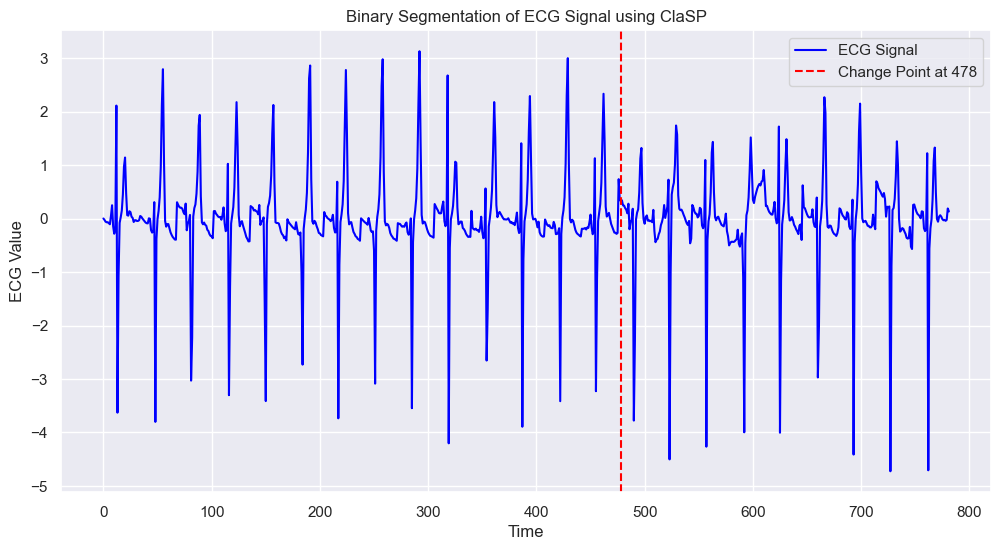

Detected change points: [478]


In [99]:
which_row = 21

# Select a single ECG signal (e.g., first row)
#signal = np.array(microsoft_stocks_dataset['Open'])
signal = tssb.loc[which_row, 'time_series']
found_cps = BinaryClaSPSegmentation().fit_predict(signal)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(signal, label="ECG Signal", color="blue")
for cp in found_cps:
    plt.axvline(x=cp, color="red", linestyle="--", label=f"Change Point at {cp}")
plt.title("Binary Segmentation of ECG Signal using ClaSP")
plt.xlabel("Time")
plt.ylabel("ECG Value")
plt.legend()
plt.show()

print("Detected change points:", found_cps)



In [100]:
tssb = load_time_series_segmentation_datasets()

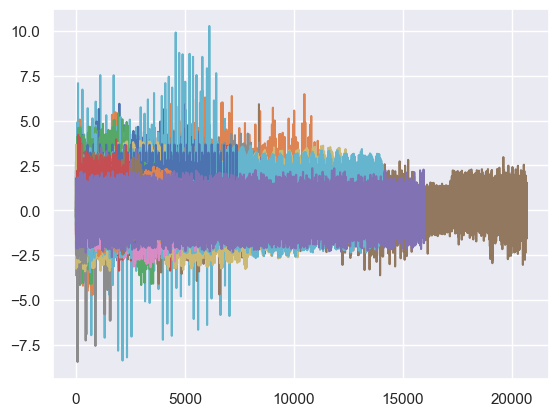

In [130]:
for row in range(0, len(tssb)):
    signal = tssb.loc[row, 'time_series']
    plt.plot(signal)
    #plt.show()